In [1]:
from keras.datasets import cifar10
import tqdm, os
from sklearn.utils import shuffle
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from src.nets.SmallFilters import SmallFilters

%matplotlib notebook

titles_list = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


train set shape: (50000, 32, 32, 3)
test set shape: (10000, 32, 32, 3)


<IPython.core.display.Javascript object>


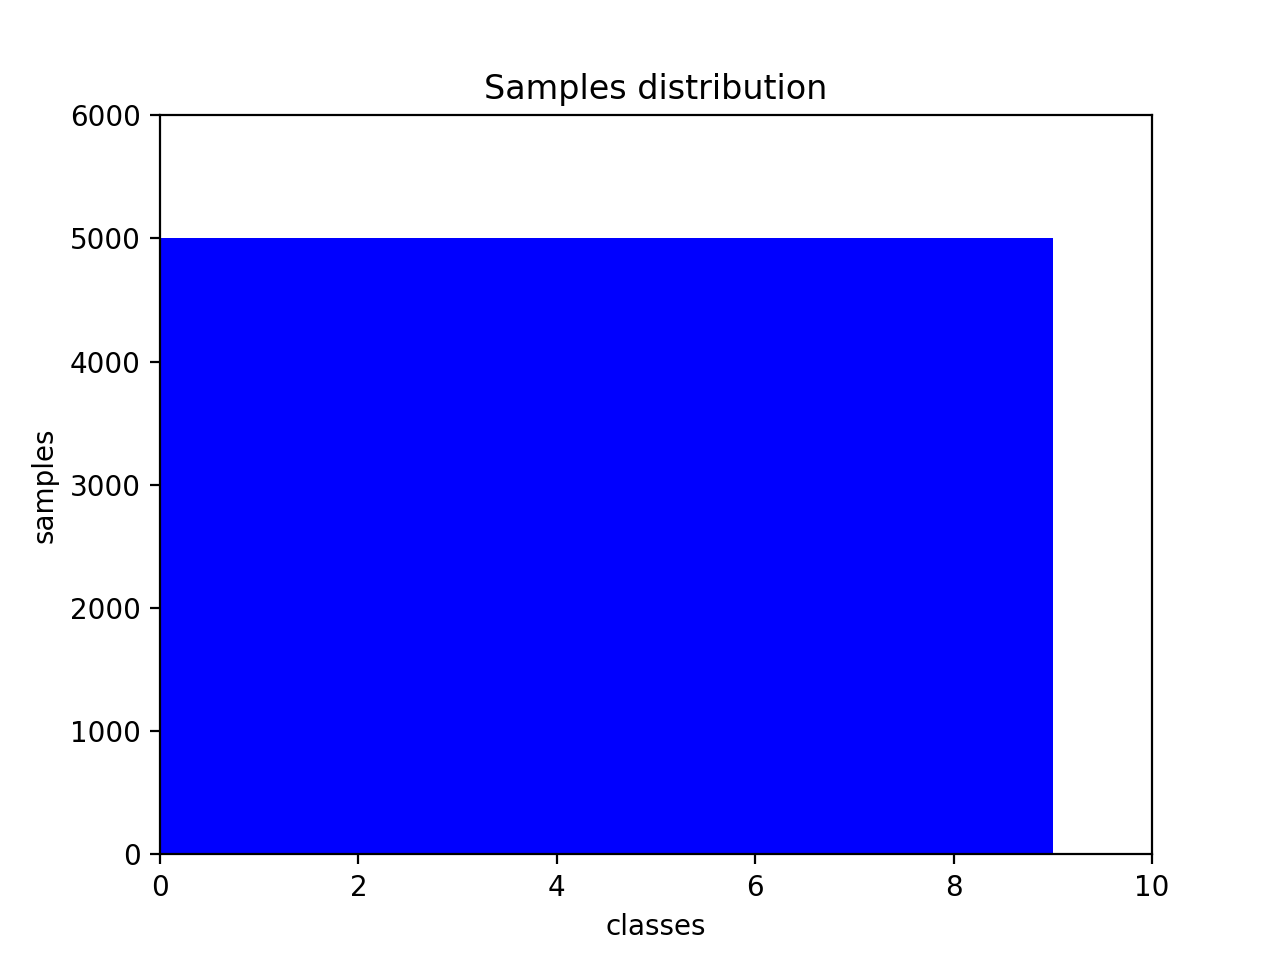

In [2]:
#provied labels contain extra dimention. To get rid of it, let's squeeze the dataset
y_train=y_train.reshape(-1)
y_test=y_test.reshape(-1)
n_classes=y_train.max()+1
#print out the stats
print("train set shape:", X_train.shape)
print("test set shape:", X_test.shape)

n, bins, patches = plt.hist(y_train,bins=y_train.max()+1, color='blue')
plt.xlabel('classes')
plt.ylabel('samples')
plt.title("Samples distribution")
plt.axis([0,10,0,6000])
plt.show()

In [3]:
#Load the metagraph of SmallFilters with batch normalization and dropout
X_ph = tf.placeholder(dtype=tf.float32, shape=(None, 32,32,3), name='X')
Y_ph = tf.placeholder(shape=(None,), name='labels', dtype=tf.int64)
net = SmallFilters(X_ph, Y_ph, 43)

Autoencoder was successfully created.
Loss definition was successfully created.
Optimization function was initialized.
SmallFilters is ready for training!


In [4]:
#Restore the session and the data
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))
new_saver = tf.train.Saver(reshape=True)

last_checkpoint = tf.train.latest_checkpoint('logs/rebalanced_set/SmallFilters')
new_saver.restore(sess, last_checkpoint)

In [5]:
#Get the accuracy opeartion from the graph
probabilities = net.probability_op
top5_probabilities = tf.nn.top_k(probabilities, k=5, name="top5")

for i in range(10):
    img = X_train[i]
    minibatch = img[np.newaxis]
    top5_prob, top5_indeces = sess.run(top5_probabilities, feed_dict={net.X: minibatch,
                                                       net.dropout_keep_rate: 1.0,
                                                       net.is_training_mode:False})
    print("{} Images. Probabilities: {:.2f},{:.2f},{:.2f},{:.2f},{:.2f}".format(titles_list[y_train[i]], *top5_prob))
    print("{} Images. Indecies: {},{},{},{},{}".format(titles_list[y_train[i]], *top5_indeces))

frog Images. Probabilities: 0.72,0.28,0.00,0.00,0.00
frog Images. Indecies: 1,2,13,14,4
truck Images. Probabilities: 0.99,0.01,0.00,0.00,0.00
truck Images. Indecies: 39,40,4,8,26
truck Images. Probabilities: 0.84,0.05,0.04,0.03,0.02
truck Images. Indecies: 1,10,40,42,12
deer Images. Probabilities: 0.66,0.23,0.05,0.04,0.03
deer Images. Indecies: 1,4,22,2,25
automobile Images. Probabilities: 1.00,0.00,0.00,0.00,0.00
automobile Images. Indecies: 39,40,12,37,4
automobile Images. Probabilities: 1.00,0.00,0.00,0.00,0.00
automobile Images. Indecies: 28,0,29,20,8
bird Images. Probabilities: 0.99,0.00,0.00,0.00,0.00
bird Images. Indecies: 32,36,4,38,13
horse Images. Probabilities: 0.61,0.38,0.00,0.00,0.00
horse Images. Indecies: 38,42,35,12,17
ship Images. Probabilities: 0.74,0.16,0.09,0.02,0.00
ship Images. Indecies: 38,36,25,20,34
cat Images. Probabilities: 0.58,0.35,0.01,0.01,0.01
cat Images. Indecies: 0,32,38,6,15


In [6]:
# Setup a new classifier for 10 classes (cifar10_classifier)
# Make sure that you stop the gradient from flowing through to limit the training to the feature extraction
feature_map = tf.stop_gradient(net.feature_map)

with tf.name_scope("cifar10_classifier"):
    shape = [net._N_CLASSES, n_classes]
    W = tf.get_variable("kernel", shape=shape, dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable("bias", shape=n_classes, dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    cifar10_logits = tf.nn.xw_plus_b(feature_map, W, b, name="logits")
    cifar10_prob = tf.nn.softmax(cifar10_logits, name="probabilities")

In [7]:
# Define loss (cifar10_loss)
with tf.name_scope('cifar10_loss'):
    cifar10_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=cifar10_logits, labels=Y_ph))

In [8]:
# Define accuracy
with tf.name_scope("cifar10_accuracy"):
    cifar10_accuracy = tf.reduce_mean(
        tf.cast(
            tf.equal(tf.arg_max(tf.nn.softmax(logits=cifar10_logits),1), Y_ph),
            dtype=tf.float32))

In [9]:
# Define optimizer
opt = tf.train.AdamOptimizer()
minimize_op = opt.minimize(cifar10_loss)

In [10]:
# Execute the training
epocs = 5
batch_size = 512
log_path = 'logs/rebalanced_set/SmallFilters'

summary_op = tf.summary.merge_all()
summary_writter = tf.summary.FileWriter(os.path.join(os.path.join(log_path, "cifar10/"), "tensorboard/"),
                                        graph=sess.graph)

sess.run(tf.global_variables_initializer())

for i in range(epocs):
    X_train, y_train = shuffle(X_train, y_train)
    pbar = tqdm.trange(0, X_train.shape[0], batch_size)
    for shift in pbar:
        shift_end = shift+batch_size
        minibatch_img = X_train[shift:shift_end]
        minibatch_indeces = y_train[shift:shift_end]
        processed_ops = [minimize_op, cifar10_loss, cifar10_accuracy]
        minibatch_feed_dict = {X_ph: minibatch_img,
                               Y_ph: minibatch_indeces,
                               net.is_training_mode: False,
                               net.dropout_keep_rate: 1.0}
        _, minibatch_loss, minibatch_acc = sess.run(processed_ops, feed_dict=minibatch_feed_dict)
        pbar.set_postfix(acc=minibatch_acc, loss=minibatch_loss)
    new_saver.save(sess, save_path=os.path.join(log_path, "cifar10/"))
    summary_writter.add_summary(sess.run(summary_op, feed_dict=minibatch_feed_dict), i)
print("Finished the training.")

100%|██████████| 98/98 [00:54<00:00,  1.96it/s, acc=0.205, loss=2.27]


Finished the training.
